This is the second in a series of notebooks designed for the "Hackathon" at the TESS Interactive Data Workshop at the 241st AAS meeting. 

The hackathon notebooks are intended to be a non-comprehensive guide on to how to approach different problems with TESS. It is up to the user to fill in the blanks to customize the notebook to their interests. Because of this, a basic knowledge of TESS data handling is prerequisite to these notebooks. 

If you are new to TESS, please first refer to the following tutorials before proceeding further.

MAST tutorials (also available on TIKE): https://github.com/spacetelescope/tike_content/blob/main/markdown/science-examples-github.md

lightkurve tutorials: https://docs.lightkurve.org/tutorials/index.html


In [1]:
%matplotlib inline

In [2]:
import lightkurve as lk
import numpy as np

In this hackathon exercise, we will look at stellar rotation periods in TESS data. In the top of this notebook, we will look at one example. Then we will suggest several different projects that can be done to explore the roation period(s) more.  

QUESTION: what steps can users take to distinguish between noise and a true rotation signal?

Stars are not perfectly steady emitters. Many stars will show regular variations in their brightess over time. In some cases, the rotation rate of the star can be inferred from these quasi-periodic changes. This is because a star's magnetic activity drives the emergence of sunspots unevenly across the surface of the star. As the starspots rotate toward and away from the viewing surface, the star's total birghtness will appear to increase and decrease.  

One way to detect this type of signal is by turning the photometric lightcurve into a periodogram. In this hackathon exercise, we will look at how to find the periodic frequency of a star. We will also discuss how you might go about determining whether the signal is genuine and reflects the star's true rotation period. 

One factor to consider going forward is the observing strategy of TESS. TESS stares at a patch of sky in 27-day Sectors, so any detected signal is limited to be less than that duration. In some cases, a target has been observed in several subsequent sectors, in which case longer signals may be detectable. However, sector-to-sector variations can make this tricky. This is certainly an interestic topic for you to explore on your own.

In [3]:
#Here let's pick a star that already has a rotation period reported in the literature. 
search_result = lk.search_lightcurve('TIC 142276270', author='SPOC', sector=(14,15))
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,142276270,0.0
1,TESS Sector 15,2019,SPOC,120,142276270,0.0


In [4]:
# Download and stitch the data together
lc = search_result.download_all().stitch() #Remember, the stitch command will normalize the data 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

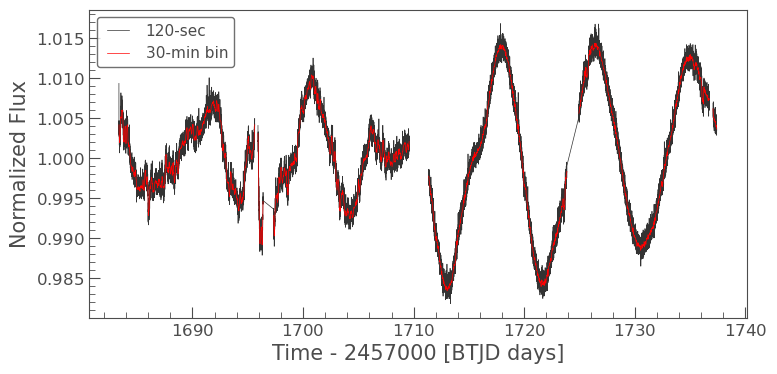

In [5]:
# Plot the resulting light curve
ax = lc.plot(label = '120-sec');
#Overplot 30-minute binned data
lc.bin(time_bin_size=30/60/24).plot(ax=ax, color='red', label='30-min bin' ) 

lightkurve includes the to_periodogram function to create either a box-least squares periodogram (useful for planet detection) or a Lomb-Scargle periodogram, which we will use here to identify an underlying periodicity. Both of these functions are based on the astropy implementation of the algorithms. If you are new to periodograms, I recommend you take some time to look into periodograms and how to understand the results before continuing. 

Check out the documentation to see more about how you can customize the periodogram
https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html

8.71572352092493 d


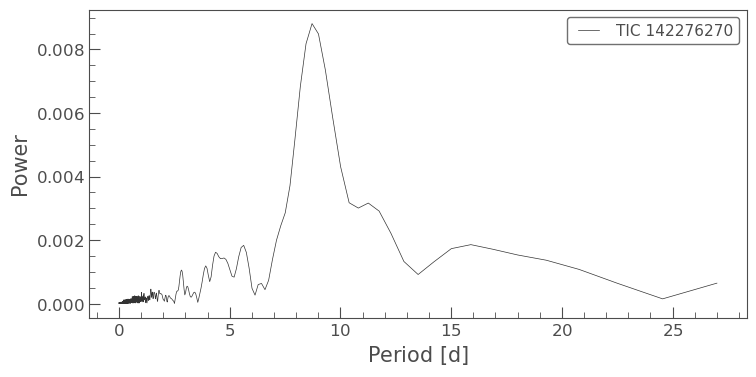

In [23]:
#As this is 2 sectors of data, this would allow at least 2 cycles. 
pg = lc.to_periodogram(maximum_period=27) 
pg.plot(view='period');
print(pg.period_at_max_power)

8.710828410941494 d


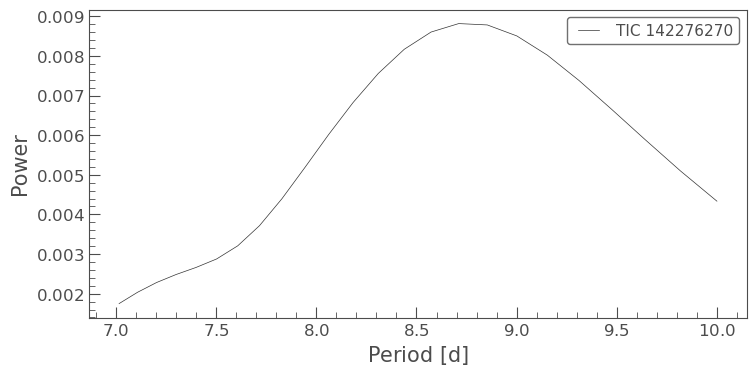

In [18]:
#Let's zoom in to that range and do a more detailed look at the peak. 
#Note that the result is fairly broad, which is typical of these quasi-periodic signals

pg_peak = lc.to_periodogram(minimum_period=7, maximum_period=10,oversample_factor=10)
pg_peak.plot(view='period');
print(pg_peak.period_at_max_power)

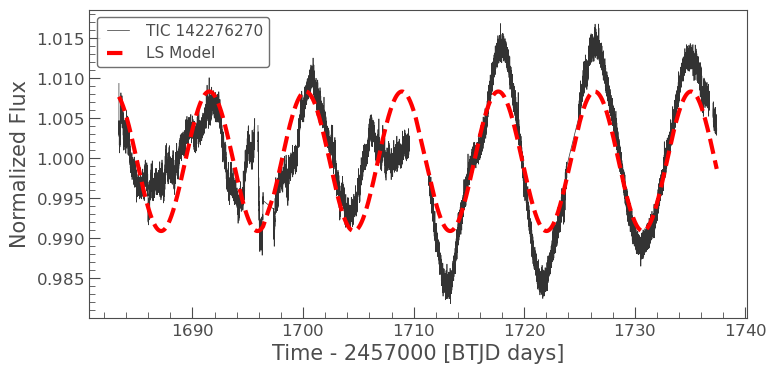

In [19]:
# Create a model light curve for the highest peak in the periodogram
lc_model = pg_peak.model(time=lc.time, frequency=pg_peak.frequency_at_max_power)
# Plot the light curve
ax = lc.plot()
# Plot the model light curve on top
lc_model.plot(ax=ax, lw=3, ls='--', c='red');


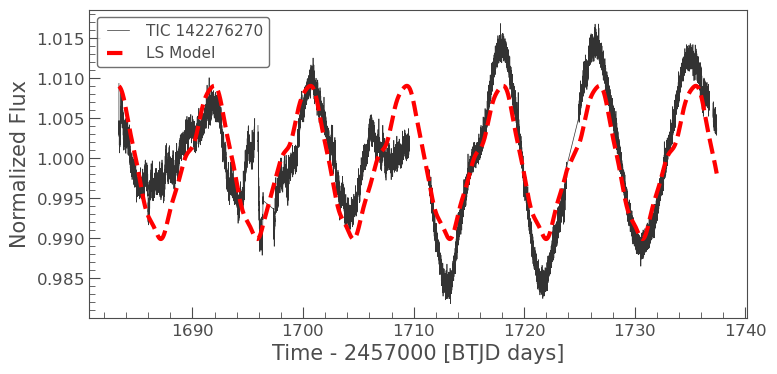

In [22]:
#Note you can also adjust the peridogram. 
#What happens if we change the number of terms to use for the Fourier fit?

pg_extraterms = lc.to_periodogram(minimum_period=7, maximum_period=10, nterms=6, ls_method='fastchi2')
lc_model_extraterms = pg_extraterms.model(time=lc.time, frequency=pg_extraterms.frequency_at_max_power)
ax = lc.plot()
lc_model_extraterms.plot(ax=ax, lw=3, ls='--', c='red');

Looks like a fairly reasonable match! The best-fitting period of 8.7d agrees with Martins et al (2020), who report a rotation period of 8.189+/-0.699d. Note that in that study, the data was cleaned and the final rotation period was determined by combining the result of multiple methods. 

This was just a quick guide to get you started. There is a lot more to explore for this topic. Below we suggest some ideas to look at for the hackathon session.


Ideas for further exploration
- In the exercise we didn't do a lot do prepare the lightcurve for analysis, other than normalize and stitch together the data. Try reducing some of the noise by, eg, removing flares, fitting a polynomial to remove longer-than-27 day variation which may come from instrument systematics, treating sectors individually, or trimming outliers from the data. 
- In this case, the variation is quite obvious. However, that will certainly not always be true. Only the Lomb-Scargle periodogram is incorporated into the lightkurve package. However, to identify a confident rotation period, it is advisable to try out different methods to see if the same signal is detected. You could take a look at alternatives such as wavelet transforms, fast fourier transforms, or even open-source machine learning models to see if the signal holds up across methods. 
- Identify a few stars that have multiple sectors of continuous coverage. Try to find the rotation period over many sectors. Repeat with a single sector. Do the results match? If not, what does that tell us? What additional problems might this create?
- Pick a sample of stars that are of interest to you (Mdwarfs, evolved stars, planet hosts, etc). Try to find rotation periods for your sample. For how many objects are rotation periods detectable? What is the distribution in rotation periods for your sample? Does it match estimations from the literature? 
    - note that the detection of a rotation signal is complicated and reflects both instrinsic stellar properties and noise properties, observing strategies, and sensitivity of the instrument. For example, CoRoT only detected rotation signals in ~5% of their sample. Kepler found a signal in ~20%. Martins et al (2020) looked at 1000 TESS TOIs with a wide range of characteristics and reported confident periodicities in about 16% of the sample.
- Incorporate a check to see if the rotation signal could be caused by blending with a nearby star.

Further reading:

There are many many studies utilizing TESS to derive the rotation from single stars to large populations. Here are a few to start out, but if you're interested there is a diverse literature out there to digest with a quick adsabs search. 

"Rotation Distributions around the Kraft Break with TESS and Kepler: The Influences of Age, Metallicity, and Binarity", Avallone et al, 2022
    
"Flare Rates, Rotation Periods, and Spectroscopic Activity Indicators of a Volume-complete Sample of Mid- to Late-M Dwarfs within 15 pc", Medina et al, 2020

"A Search for Rotation Periods in 1000 TESS Objects of Interest", Martins et al, 2020

"Complex Rotational Modulation of Rapidly Rotating M Stars Observed with TESS", Zhan et al, 2019